# OpenMATB Session Performance Analysis

This notebook extracts all 'performance' rows from OpenMATB log files, links key press actions that resolve failures, reshapes the data, and analyzes performance between users.

In [14]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [20]:
# Load and Preview CSV Data
# Change this path to your target log file or use glob to load multiple files
csv_files = glob.glob(os.path.join('sessions', '*', '*.csv'))

print(f"Found {len(csv_files)} CSV files.")

# For demonstration, load the first file
log_file = csv_files[0]
df = pd.read_csv(log_file)
df.head()

Found 203 CSV files.


,logtime,scenario_time,type,module,address,value
0,125098.876618,0.0,version,NaN,NaN,1.4.1
1,125098.878150,0.0,scenario_path,NaN,NaN,includes/scenarios/default_en.txt
2,125098.878505,0.0,seed_value,communications,NaN,NaN
3,125098.878514,0.0,seed_output,communications,NaN,ZIK333
4,125098.878557,0.0,seed_value,communications,NaN,NaN


In [16]:
# Extract Performance Rows
performance_df = df[df['type'] == 'performance'].copy()
performance_df.reset_index(drop=True, inplace=True)
performance_df.head()

,logtime,scenario_time,type,module,address,value
0,125101.125180,0.096048,performance,resman,a_in_tolerance,1
1,125101.125189,0.096048,performance,resman,a_deviation,0
2,125101.125196,0.096048,performance,resman,b_in_tolerance,1
3,125101.125201,0.096048,performance,resman,b_deviation,0
4,125103.134333,2.105191,performance,resman,a_in_tolerance,1


In [21]:
# Identify and Link Key Press Actions
# For each performance row, check if the next row is a key press event
key_press_types = ['input']
key_press_modules = ['keyboard']
key_press_column = []

for idx in performance_df.index:
    # Look for the next row in the original df
    orig_idx = performance_df.index[idx]
    if orig_idx + 1 < len(df):
        next_row = df.iloc[orig_idx + 1]
        if next_row['type'] in key_press_types and next_row['module'] in key_press_modules:
            key_press_column.append(next_row['address'])
        else:
            key_press_column.append(None)
    else:
        key_press_column.append(None)

performance_df['key_press'] = key_press_column
performance_df.head()

,logtime,scenario_time,type,module,address,value,key_press
0,125101.125180,0.096048,performance,resman,a_in_tolerance,1,None
1,125101.125189,0.096048,performance,resman,a_deviation,0,None
2,125101.125196,0.096048,performance,resman,b_in_tolerance,1,None
3,125101.125201,0.096048,performance,resman,b_deviation,0,None
4,125103.134333,2.105191,performance,resman,a_in_tolerance,1,None


In [22]:
# Reshape Data: Add Key Press Column
# Already done above, but let's clean up and show only relevant columns
reshaped_df = performance_df[['logtime', 'scenario_time', 'module', 'address', 'value', 'key_press']]
reshaped_df.head()

,logtime,scenario_time,module,address,value,key_press
0,125101.125180,0.096048,resman,a_in_tolerance,1,None
1,125101.125189,0.096048,resman,a_deviation,0,None
2,125101.125196,0.096048,resman,b_in_tolerance,1,None
3,125101.125201,0.096048,resman,b_deviation,0,None
4,125103.134333,2.105191,resman,a_in_tolerance,1,None


In [24]:
# Aggregate Performance Data by User
# Extract user/session from filename
reshaped_df['session_file'] = log_file
reshaped_df['user'] = reshaped_df['session_file'].apply(lambda x: os.path.basename(x).split('_')[1] if '_' in os.path.basename(x) else 'unknown')

# If analyzing multiple files, concatenate all
all_reshaped = []
for file in csv_files:
    # Skip empty files
    try:
        temp_df = pd.read_csv(file)
    except pd.errors.EmptyDataError:
        print(f"Skipped empty file: {file}")
        continue
    if temp_df.empty or not set(['type', 'logtime', 'scenario_time', 'module', 'address', 'value']).issubset(temp_df.columns):
        print(f"Skipped file with missing columns: {file}")
        continue
    perf_df = temp_df[temp_df['type'] == 'performance'].copy()
    key_press_column = []
    for i in range(len(perf_df)):
        orig_idx = perf_df.index[i]
        if orig_idx + 1 < len(temp_df):
            next_row = temp_df.iloc[orig_idx + 1]
            if next_row['type'] == 'input' and next_row['module'] == 'keyboard':
                key_press_column.append(next_row['address'])
            else:
                key_press_column.append(None)
        else:
            key_press_column.append(None)
    perf_df['key_press'] = key_press_column
    perf_df['session_file'] = file
    perf_df['user'] = os.path.basename(file).split('_')[1] if '_' in os.path.basename(file) else 'unknown'
    all_reshaped.append(perf_df[['logtime', 'scenario_time', 'module', 'address', 'value', 'key_press', 'user']])

if all_reshaped:
    final_df = pd.concat(all_reshaped, ignore_index=True)
    final_df.head()
else:
    print("No valid dataframes to concatenate.")

Skipped empty file: sessions/2025-07-14/82_250714_142828.csv
Skipped empty file: sessions/2025-07-14/74_250714_131715.csv
Skipped empty file: sessions/2025-07-14/86_250714_144652.csv
Skipped empty file: sessions/2025-07-14/94_250714_150942.csv
Skipped empty file: sessions/2025-07-14/68_250714_125659.csv
Skipped empty file: sessions/2025-07-14/80_250714_142357.csv
Skipped empty file: sessions/2025-07-14/64_250714_124204.csv
Skipped empty file: sessions/2025-07-14/90_250714_145619.csv
Skipped empty file: sessions/2025-07-14/88_250714_145413.csv
Skipped empty file: sessions/2025-07-14/60_250714_121601.csv
Skipped empty file: sessions/2025-07-14/72_250714_131443.csv
Skipped empty file: sessions/2025-07-14/62_250714_121919.csv
Skipped empty file: sessions/2025-07-14/84_250714_143231.csv
Skipped empty file: sessions/2025-07-14/70_250714_130825.csv
Skipped empty file: sessions/2025-07-14/76_250714_140357.csv
Skipped empty file: sessions/2025-07-14/66_250714_124427.csv
Skipped empty file: sess

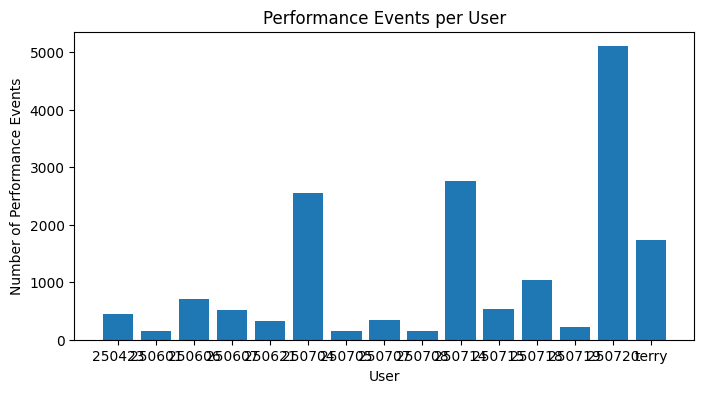

In [25]:
# Analyze Performance Metrics Between Users
# Example: Compute success rate and average response time per user
# You may need to adjust 'address' and 'value' columns depending on your definition of success

# Example: Count number of performance events per user
perf_counts = final_df.groupby('user').size().reset_index(name='performance_events')

# Example: Average value (if numeric) per user
if pd.api.types.is_numeric_dtype(final_df['value']):
    avg_value = final_df.groupby('user')['value'].mean().reset_index(name='avg_value')
else:
    avg_value = None

# Visualize
plt.figure(figsize=(8,4))
plt.bar(perf_counts['user'], perf_counts['performance_events'])
plt.xlabel('User')
plt.ylabel('Number of Performance Events')
plt.title('Performance Events per User')
plt.show()

if avg_value is not None:
    plt.figure(figsize=(8,4))
    plt.bar(avg_value['user'], avg_value['avg_value'])
    plt.xlabel('User')
    plt.ylabel('Average Value')
    plt.title('Average Performance Value per User')
    plt.show()

In [26]:
# Differentiate Performance by Task/Module and Extract Raw Values
# Filter and group by module (task): sysmon, resman, communication, etc.

# Example: List unique modules
print('Unique modules:', final_df['module'].unique())

# Extract raw performance values for each task
for module in final_df['module'].unique():
    print(f'--- Performance for {module} ---')
    module_df = final_df[final_df['module'] == module]
    # Show raw values (address and value columns)
    display(module_df[['address', 'value', 'key_press', 'user']].head(10))

# Optionally, aggregate by module and user
agg = final_df.groupby(['user', 'module', 'address', 'value']).size().reset_index(name='count')
display(agg.head(20))

Unique modules: ['resman' 'sysmon' 'communications' 'genericscales' 'resman_vocal'
 'sysmon_vocal' 'communications_vocal' 'resman_vv' 'sysmon_vv'
 'communications_vv' 'resman_visual' 'sysmon_visual'
 'communications_visual']
--- Performance for resman ---


,address,value,key_press,user
0,a_in_tolerance,1,None,250714
1,a_deviation,0,None,250714
2,b_in_tolerance,1,None,250714
3,b_deviation,0,None,250714
4,a_in_tolerance,1,None,250714
5,a_deviation,-26,None,250714
6,b_in_tolerance,1,None,250714
7,b_deviation,-26,None,250714
8,a_in_tolerance,1,None,250714
9,a_deviation,-52,None,250714


--- Performance for sysmon ---


,address,value,key_press,user
20,name,F1,None,250714
21,signal_detection,HIT,None,250714
22,response_time,8000,F1,250714
23,name,F5,None,250714
24,signal_detection,HIT,None,250714
25,response_time,4000,F5,250714
79,name,F6,None,250714
80,signal_detection,HIT,None,250714
81,response_time,3800,F6,250714
111,name,F3,None,250714


--- Performance for communications ---


,address,value,key_press,user
94,target_radio,NAV_1,None,250714
95,target_frequency,126.6,None,250714
96,response_was_needed,1,None,250714
97,responded_radio,NaN,None,250714
98,responded_frequency,NaN,None,250714
99,correct_radio,0,None,250714
100,response_deviation,NaN,None,250714
101,response_time,NaN,None,250714
102,sdt_value,MISS,None,250714
255,target_radio,COM_1,None,250714


--- Performance for genericscales ---


,address,value,key_press,user
154,Mental demand,5,None,250714
155,Physical demand,5,None,250714
156,Time pressure,5,None,250714
157,Performance,5,None,250714
158,Effort,5,None,250714
159,Frustration,5,None,250714
315,Mental demand,5,None,250714
316,Physical demand,5,None,250714
317,Time pressure,5,None,250714
318,Performance,5,None,250714


--- Performance for resman_vocal ---


,address,value,key_press,user
5393,a_in_tolerance,1,None,terry
5394,a_deviation,0,None,terry
5395,b_in_tolerance,1,None,terry
5396,b_deviation,0,None,terry
5397,a_in_tolerance,1,None,terry
5398,a_deviation,-26,None,terry
5399,b_in_tolerance,1,None,terry
5400,b_deviation,-26,None,terry
5401,a_in_tolerance,1,None,terry
5402,a_deviation,-52,None,terry


--- Performance for sysmon_vocal ---


,address,value,key_press,user
5425,name,F6,None,terry
5426,signal_detection,MISS,None,terry
5427,response_time,NaN,None,terry
5448,name,F3,None,terry
5449,signal_detection,MISS,None,terry
5450,response_time,NaN,None,terry
5503,name,F6,None,terry
5504,signal_detection,MISS,None,terry
5505,response_time,NaN,None,terry
5526,name,F3,None,terry


--- Performance for communications_vocal ---


,address,value,key_press,user
5584,target_radio,NAV_1,None,terry
5585,target_frequency,131.1,None,terry
5586,response_was_needed,1,None,terry
5587,responded_radio,NaN,None,terry
5588,responded_frequency,NaN,None,terry
5589,correct_radio,0,None,terry
5590,response_deviation,NaN,None,terry
5591,response_time,NaN,None,terry
5592,sdt_value,MISS,None,terry
5681,target_radio,COM_2,None,terry


--- Performance for resman_vv ---


,address,value,key_press,user
5800,a_in_tolerance,1,None,terry
5801,a_deviation,0,None,terry
5802,b_in_tolerance,1,None,terry
5803,b_deviation,0,None,terry
6795,a_in_tolerance,1,None,250720
6796,a_deviation,0,None,250720
6797,b_in_tolerance,1,None,250720
6798,b_deviation,0,None,250720
6799,a_in_tolerance,1,None,250720
6800,a_deviation,-26,None,250720


--- Performance for sysmon_vv ---


,address,value,key_press,user
6835,name,F1,None,250720
6836,signal_detection,MISS,None,250720
6837,response_time,NaN,None,250720
6843,name,F5,None,250720
6844,signal_detection,MISS,None,250720
6845,response_time,NaN,None,250720
6866,name,F6,None,250720
6867,signal_detection,MISS,None,250720
6868,response_time,NaN,None,250720
6890,name,F3,None,250720


--- Performance for communications_vv ---


,address,value,key_press,user
6877,target_radio,NAV_2,None,250720
6878,target_frequency,119.5,None,250720
6879,response_was_needed,1,None,250720
6880,responded_radio,NaN,None,250720
6881,responded_frequency,NaN,None,250720
6882,correct_radio,0,None,250720
6883,response_deviation,NaN,None,250720
6884,response_time,NaN,None,250720
6885,sdt_value,MISS,None,250720
6948,target_radio,NAV_1,None,250720


--- Performance for resman_visual ---


,address,value,key_press,user
7614,a_in_tolerance,1,None,250720
7615,a_deviation,0,None,250720
7616,b_in_tolerance,1,None,250720
7617,b_deviation,0,None,250720
7618,a_in_tolerance,1,None,250720
7619,a_deviation,-26,None,250720
7620,b_in_tolerance,1,None,250720
7621,b_deviation,-26,None,250720
7622,a_in_tolerance,1,None,250720
7623,a_deviation,-52,None,250720


--- Performance for sysmon_visual ---


,address,value,key_press,user
7654,name,F1,None,250720
7655,signal_detection,MISS,None,250720
7656,response_time,NaN,None,250720
7662,name,F5,None,250720
7663,signal_detection,MISS,None,250720
7664,response_time,NaN,None,250720
7694,name,F6,None,250720
7695,signal_detection,MISS,None,250720
7696,response_time,NaN,None,250720
7709,name,F3,None,250720


--- Performance for communications_visual ---


,address,value,key_press,user
7673,target_radio,COM_2,None,250720
7674,target_frequency,117.4,None,250720
7675,response_was_needed,1,None,250720
7676,responded_radio,NaN,None,250720
7677,responded_frequency,NaN,None,250720
7678,correct_radio,0,None,250720
7679,response_deviation,NaN,None,250720
7680,response_time,NaN,None,250720
7681,sdt_value,MISS,None,250720
7747,target_radio,COM_2,None,250720


,user,module,address,value,count
0,250423,communications,correct_radio,0,3
1,250423,communications,response_was_needed,1,3
2,250423,communications,sdt_value,MISS,3
3,250423,communications,target_frequency,120.2,1
4,250423,communications,target_frequency,120.5,1
5,250423,communications,target_frequency,130.3,1
6,250423,communications,target_radio,COM_1,1
7,250423,communications,target_radio,NAV_1,2
8,250423,genericscales,Effort,5,2
9,250423,genericscales,Effort,7.679796,1


In [ ]:
# Extract and Pivot Performance Data for Each Task Type Separately
# Create a table for each task (module) with users as rows and performance fields as columns

task_tables = {}
for module in final_df['module'].unique():
    module_df = final_df[final_df['module'] == module]
    # Pivot so each performance field (address) is a column
    pivot = module_df.pivot_table(index='user', columns='address', values='value', aggfunc='first')
    task_tables[module] = pivot
    print(f'Performance table for task: {module}')
    display(pivot)

# Now you have a dictionary 'task_tables' with a table for each task type (module)
# Each table has users as rows and performance fields as columns